Tests: fourier descriptor based on centroid distance

In [3]:
import os
import sys

In [7]:
sys.path.append(os.path.dirname(os.getcwd()))

In [9]:
import numpy as np
import pandas as pd 
from math import sqrt
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from itertools import cycle

from random import randint
from random import sample

import xgboost as xgb
import utils.shapeFeatures_extraction 
import csv
IMG_W = 1376
IMG_H = 1020

In [13]:
## Fetch above file 
df_cell_masks = pd.read_pickle(os.path.join(os.path.dirname(os.getcwd()), 'files', 'CRIC_data_mask_cells.csv'))
df_cell_masks

,image_id,cell_id,bethesda,image_filename,nparray_points_segm_Nucleus,nparray_points_segm_Cyto
0,1,14796,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[398, 157], [398, 156], [398, 155], [398, 155...","[[467, 232], [468, 232], [469, 232], [470, 232..."
1,1,14797,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[474, 379], [474, 378], [474, 378], [473, 378...","[[526, 418], [526, 417], [526, 416], [526, 415..."
2,1,14798,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[545, 983], [544, 983], [544, 983], [544, 982...","[[442, 870], [441, 870], [440, 870], [439, 870..."
3,1,14799,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[278, 124], [278, 124], [279, 124], [279, 124...","[[242, 44], [241, 44], [240, 44], [240, 44], [..."
4,1,14801,0,be340ee72689dfe3f8dc9c24de6127f4.png,"[[140, 217], [139, 217], [139, 217], [138, 217...","[[238, 197], [238, 196], [238, 195], [238, 194..."
...,...,...,...,...,...,...
3228,399,11539,5,dc2df7c3f88649ded343b13b9486cddf.png,"[[405, 562], [405, 563], [405, 563], [404, 563...","[[360, 542], [360, 543], [360, 543], [361, 543..."
3229,399,11540,5,dc2df7c3f88649ded343b13b9486cddf.png,"[[510, 498], [509, 498], [509, 498], [509, 499...","[[496, 439], [496, 440], [496, 440], [495, 441..."
3230,400,11535,5,9ae8a4edde40219bad6303cebc672ee4.png,"[[454, 782], [454, 783], [454, 783], [453, 783...","[[429, 737], [428, 737], [428, 737], [428, 738..."
3231,400,11536,5,9ae8a4edde40219bad6303cebc672ee4.png,"[[672, 596], [672, 597], [672, 597], [672, 597...","[[688, 492], [689, 492], [689, 492], [689, 493..."


In [ ]:
 img = CRIC_images()
   #cont = 0
   count_cells = np.zeros(6, dtype = int)
   aux = df_cell_masks.keys()[0:3]
   for image_id, cell_id, bethesda in df_cell_masks[aux].values:   
        cell = f'{image_id:05d}_{cell_id:05d}_'
                
        ## contornos                                                             
        points_N = df_cell_masks.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))['nparray_points_segm_Nucleus'].values[0] 
        points_C = df_cell_masks.query('image_id == '+str(image_id) + ' and cell_id == '+str(cell_id))['nparray_points_segm_Cyto'].values[0]
                    
        # Calc regionprops metrics from Nucleos mask:
        mask_nucleo =  np.zeros((img.IMG_H, img.IMG_W), dtype=np.uint8)
        mask_nucleo[points_N[:,0],points_N[:,1]] = 1
        m_N = measure.regionprops(mask_nucleo)  
        # Calc regionprops metrics from Cyto mask:
        mask_cyto =  np.zeros((img.IMG_H, img.IMG_W), dtype=np.uint8)
        mask_cyto[points_C[:,0],points_C[:,1]] = 1
        m_C = measure.regionprops(mask_cyto)

In [2]:
 
x = xt[1::] 
y = yt[1::] 
xc = np.sum(x)/x.shape[-1]
yc = np.sum(y)/x.shape[-1]
t = np.arange(x.shape[-1])
rt = np.sqrt((x-xc)**2 + (y-yc)**2)  #centroid distances

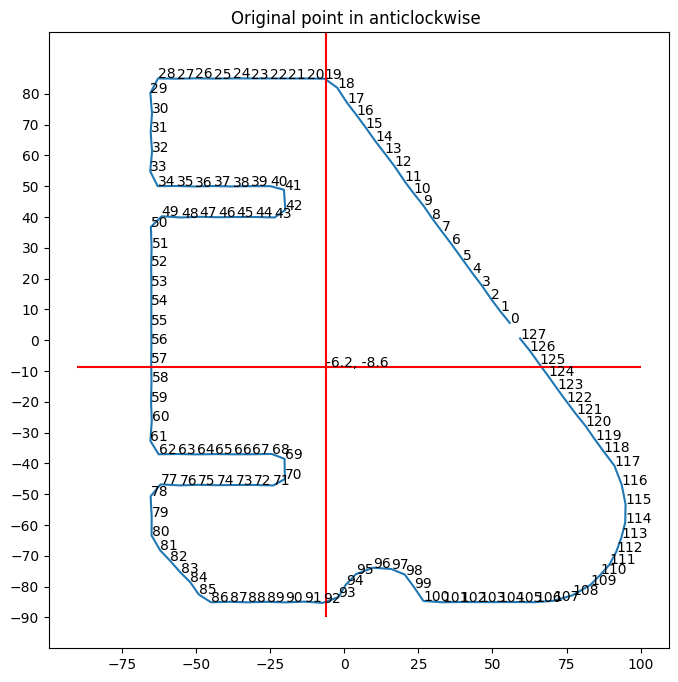

In [13]:
plt.figure(figsize=(8,8))
plt.plot(x, y, xc, yc)
plt.ylim(-100,100)
plt.yticks(np.arange(-90,90,10))
plt.title("Original point in anticlockwise ")
plt.text(xc,yc, '{:.1f}, {:.1f}'.format(xc, yc))
for i in np.arange(0, x.shape[-1], 1): 
    plt.text(x[i], y[i], '{:d}'.format(i))
plt.hlines( yc, -90, 100, 'r')
plt.vlines( xc, -90, 100, 'r')

In [4]:
# Função filtro gauss:
def gaus_filter(n, n_median, sig):
   # n: numero de dados
   #n_median: posição para o vr maximo da curva de Gaus (ex. n/2) 
   #sigma: desvio padrão da gausiana
   gaus_f = np.zeros(n, dtype = complex)   
   for i in np.arange(n):
      gaus_f[i] = (1./(sig*(np.sqrt(2*np.pi))))*np.exp((-1*(i- n_median)**2)/(2*sig**2))
   return gaus_f
 
# Calcula o espectro de energia do vetor transformado antes da gaussina
def total_energy(fft_x):
   real = np.real(fft_x)**2
   imag = np.imag(fft_x)**2
   return (real + imag)

def calc_energy(tf):
    et = np.zeros(tf.shape[0], dtype = np.float64)
    for i in np.arange(tf.shape[0]):
        et[i] = (np.real(tf[i])**2) + (np.imag(tf[i])**2) 
    return et, np.sum(et)

def gaus_smooth_signal (x, sigma):
   n = x.shape[-1]
   gaus_f = gaus_filter(n, n/2, sigma)
   trans_gaus = np.fft.fft(gaus_f)
   trans_x=(np.fft.fft(x))
   trans_x = trans_x * trans_gaus
   itrans_x = np.fft.fftshift(np.fft.ifft(trans_x))
   return (itrans_x, gaus_f) 

# Calcula x'(t),x''(t), y'(t), y''(t), a partir de Fourier:
def derivatives(fft_x, freqs_x):   
   dx =  freqs_x*1j
   dx2 = dx**2
   dF = np.fft.fftshift(np.fft.ifft(fft_x*dx))
   d2F= np.fft.fftshift(np.fft.ifft(fft_x*dx2))
   return ((dF), (d2F))

# Calcula FFT e frequencias  
def fft_freqs(x):
   return (np.fft.fft(x), np.fft.fftfreq(x.shape[-1]))

# Calcula Curvatures
def curvatures(dx, dx2, dy, dy2):
   n= (dx[t]*dy2[t]) - (dy[t]*dx2[t])
   d= ((dx[t]**2) + (dy[t]**2))**(3.0/2)
   return (n/d) 

import math

def rotate(origin, px, py, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

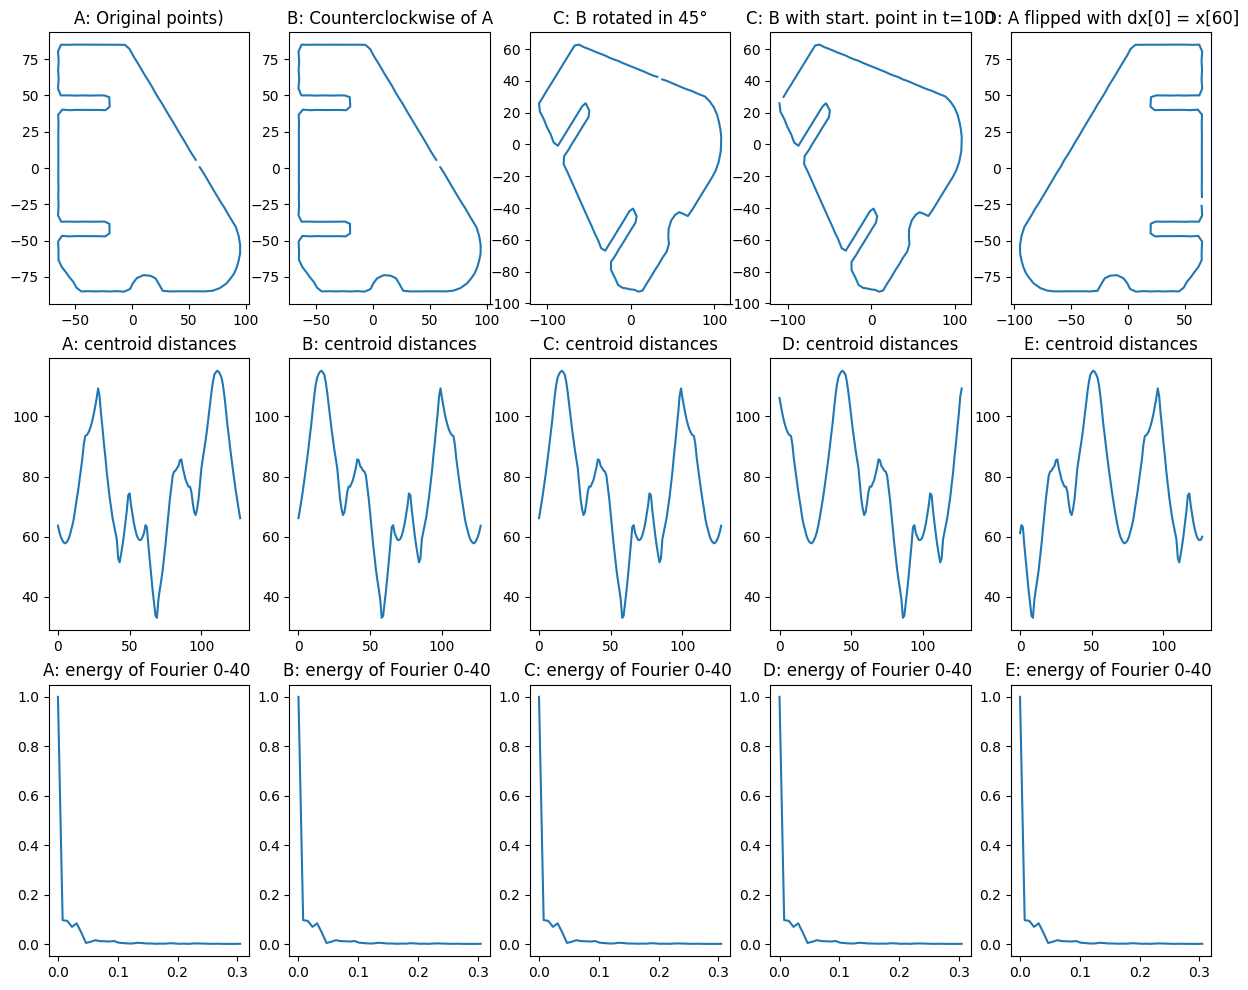

In [43]:
# --- Calc FD 
fft_y, freqs = fft_freqs(rt)
fft_y = fft_y/fft_y[0]

fft_y2, freqs2 = fft_freqs(rt2)
fft_y2 = fft_y2/fft_y2[0]

fft_y2i, freqs2i = fft_freqs(rt2i)
fft_y2i = fft_y2i/fft_y2i[0]

fft_ya, freqsa = fft_freqs(a_rt)
fft_ya = fft_ya/fft_ya[0]

fft_y4, freqs4 = fft_freqs(x4r)
fft_y4 = fft_y4/fft_y4[0]

fig, axis = plt.subplots(3, 5, figsize=(15,12))
axis[0,0].plot(x, y) 
axis[0,0].set_title("A: Original points)")
axis[0,1].plot(x2, y2) 
axis[0,1].set_title("B: Counterclockwise of A") 
axis[0,2].plot(x2i, y2i) 
axis[0,2].set_title("C: B rotated in 45°") 
axis[0,3].plot(a_x, a_y)
axis[0,3].set_title("C: B with start. point in t=100") 
axis[0,4].plot(x4, y4)
axis[0,4].set_title("D: A flipped with dx[0] = x[60]")

axis[1,0].plot(np.arange(128), rt)
axis[1,0].set_title("A: centroid distances")
axis[1,1].plot(np.arange(128), rt2)
axis[1,1].set_title("B: centroid distances")
axis[1,2].plot(np.arange(128), rt2i)
axis[1,2].set_title("C: centroid distances")
axis[1,3].plot(np.arange(128), a_rt)
axis[1,3].set_title("D: centroid distances")
axis[1,4].plot(np.arange(128), x4r)
axis[1,4].set_title("E: centroid distances")

axis[2,0].plot(freqs[0:40], (np.sqrt((np.real(fft_y))**2 + (np.imag(fft_y))**2))[0:40]) 
axis[2,0].set_title("A: energy of Fourier 0-40 ")
axis[2,1].plot(freqs2[0:40], np.sqrt((np.real(fft_y2))**2 + (np.imag(fft_y2))**2)[0:40])  
axis[2,1].set_title("B: energy of Fourier 0-40 ")
axis[2,2].plot(freqs2i[0:40], np.sqrt((np.real(fft_y2i))**2 + (np.imag(fft_y2i))**2)[0:40]) 
axis[2,2].set_title("C: energy of Fourier 0-40 ")
axis[2,3].plot(freqsa[0:40], np.sqrt((np.real(fft_ya))**2 + (np.imag(fft_ya))**2)[0:40])
axis[2,3].set_title("D: energy of Fourier 0-40 ")
axis[2,4].plot(freqs4[0:40], np.sqrt((np.real(fft_y4))**2 + (np.imag(fft_y4))**2)[0:40])
axis[2,4].set_title("E: energy of Fourier 0-40 ")
plt.show()

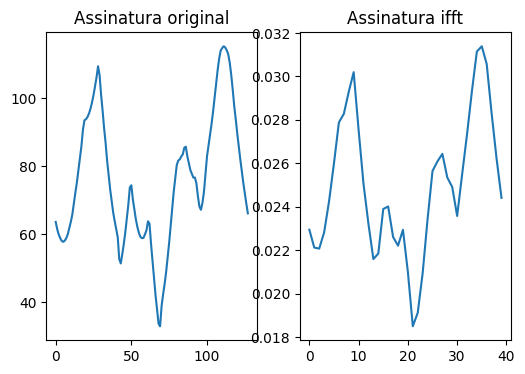

In [219]:
fig, axis = plt.subplots(1, 4, figsize=(6,4))
axis[0].plot(np.arange(128), rt )
axis[0].set( title = 'Assinatura original') 

axis[1].plot(np.arange(128)[0:40], np.fft.ifft(fft_y[0:40]))
axis[1].set( title = 'Assinatura ifft') 

axis[2].plot((xc+rt), (yc+rt) )
axis[2].set( title = 'Assinatura original') 

axis[3].plot(np.arange(128)[0:40], np.fft.ifft(fft_y[0:40]))
axis[3].set( title = 'Assinatura ifft') 
plt.show()